# Yield Prediction Using Reaction SMILES + BERT

**Approach:** Use pre-trained RXNBERT to encode entire reactions as 256-dimensional vectors, then train a neural network.

**Key difference from one-hot encoding:**
- One-hot: Treats each component as independent category
- BERT: Understands chemical structure and reaction context
- Uses full Reaction SMILES format: `reactants>agents>products`

**Dataset:** Ahneman Buchwald-Hartwig C-N Coupling (4312 reactions)

## 1. Setup and Installation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ORD for loading dataset
from ord_schema import message_helpers
from ord_schema.proto import dataset_pb2, reaction_pb2

# RXNBERT for reaction embeddings
from rxnfp.transformer_fingerprints import RXNBERTFingerprintGenerator

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow import keras

sns.set_style("whitegrid")
np.random.seed(42)
tf.random.set_seed(42)

2026-02-11 18:15:16.561521: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-11 18:15:16.630133: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✓ All packages imported successfully


2026-02-11 18:15:18.283776: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## 2. Load Dataset

In [2]:
# Load Ahneman dataset
dataset_path = "ord-data/data/46/ord_dataset-46ff9a32d9e04016b9380b1b1ef949c3.pb.gz"
data = message_helpers.load_message(dataset_path, dataset_pb2.Dataset)

print(f"Dataset: {data.name}")
print(f"Description: {data.description}")
print(f"Reactions: {len(data.reactions)}")

Dataset: Ahneman
Description: C-N cross-coupling reactions from 10.1126/science.aar5169
Reactions: 4312


## 3. Build Reaction SMILES

Convert each reaction to format: `reactants>agents>products`

For Buchwald-Hartwig:
- Reactants: aryl halide + amine
- Agents: catalyst + base + additive (+ solvent)
- Products: coupled product

In [21]:
def extract_smiles_from_component(component):
    """Extract SMILES from a reaction component."""
    for ident in component.identifiers:
        ident_type = reaction_pb2.CompoundIdentifier.CompoundIdentifierType.Name(ident.type)
        if ident_type == "SMILES":
            return ident.value
    return None

def build_reaction_smiles(reaction):
    """
    Build Reaction SMILES: reactants>agents>products
    
    Returns:
        reaction_smiles: String in format "reactant1.reactant2>agent1.agent2>product"
        yield_val: Reaction yield percentage
    """
    reactants = []
    agents = []
    products = []
    
    # Extract inputs
    for key, inp in reaction.inputs.items():
        for comp in inp.components:
            role = reaction_pb2.ReactionRole.ReactionRoleType.Name(comp.reaction_role)
            smiles = extract_smiles_from_component(comp)
            
            if smiles:
                if role == "REACTANT":
                    reactants.append(smiles)
                elif role in ["CATALYST", "REAGENT"]:
                    agents.append(smiles)
                # Skip SOLVENT (often just DMSO, not informative)
    
    # Extract products
    for outcome in reaction.outcomes:
        for product in outcome.products:
            smiles = extract_smiles_from_component(product)
            if smiles:
                products.append(smiles)
    
    # Extract yield
    yield_val = None
    for outcome in reaction.outcomes:
        for product in outcome.products:
            for meas in product.measurements:
                if meas.type == reaction_pb2.ProductMeasurement.ProductMeasurementType.YIELD:
                    yield_val = meas.percentage.value
                    break
    
    # Build reaction SMILES
    reactant_str = ".".join(reactants) if reactants else ""
    agent_str = ".".join(agents) if agents else ""
    product_str = ".".join(products) if products else ""
    
    reaction_smiles = f"{reactant_str}>{agent_str}>{product_str}"
    
    return reaction_smiles, yield_val

# Process all reactions
print("Building Reaction SMILES for all reactions...")
reaction_data = []

for rxn in tqdm(data.reactions):
    rxn_smiles, yield_val = build_reaction_smiles(rxn)
    
    if yield_val is not None: 
        reaction_data.append({
            'reaction_smiles': rxn_smiles,
            'yield': yield_val
        })

df = pd.DataFrame(reaction_data)

Building Reaction SMILES for all reactions...


100%|██████████| 4312/4312 [00:00<00:00, 35497.16it/s]


In [23]:
# Save all Reaction SMILES to text and a CSV file
print("Saving Reaction SMILES to file...")

with open('reaction_smiles_all.txt', 'w') as f:
    f.write("="*80 + "\n")
    f.write("ALL REACTION SMILES - Ahneman Buchwald-Hartwig Dataset\n")
    f.write("="*80 + "\n\n")
    
    for i, row in df.iterrows():
        f.write(f"Reaction {i+1}:\n")
        f.write(f"  Yield: {row['yield']:.2f}%\n")
        f.write(f"  SMILES: {row['reaction_smiles']}\n")
        f.write("-"*80 + "\n\n")

print(f"Saved {len(df)} Reaction SMILES to 'reaction_smiles_all.txt'")


df[['reaction_smiles', 'yield']].to_csv('reaction_smiles_data.csv', index=False)
print("Saved CSV: 'reaction_smiles_data.csv'")

Saving Reaction SMILES to file...
Saved 4312 Reaction SMILES to 'reaction_smiles_all.txt'
Saved CSV: 'reaction_smiles_data.csv'


Yield statistics:
  Mean:   32.9%
  Median: 28.4%
  Std:    27.5%
  Min:    0.0%
  Max:    100.0%


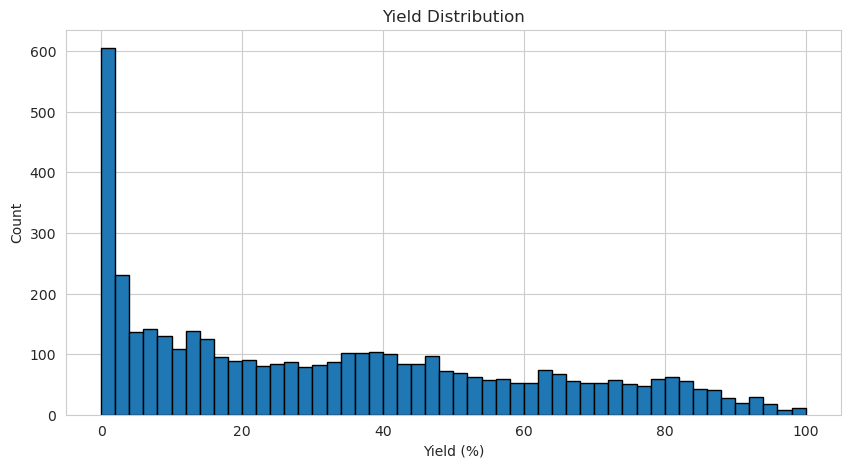

In [ ]:
# Yield distribution
print(f"Yield statistics:")
print(f"  Mean:   {df['yield'].mean():.1f}%")
print(f"  Median: {df['yield'].median():.1f}%")
print(f"  Std:    {df['yield'].std():.1f}%")
print(f"  Min:    {df['yield'].min():.1f}%")
print(f"  Max:    {df['yield'].max():.1f}%")

plt.figure(figsize=(10, 5))
plt.hist(df['yield'], bins=50, edgecolor='black')
plt.xlabel('Yield (%)')
plt.ylabel('Count')
plt.title('Yield Distribution')
plt.show()

## 4. Initialize ChemBERTa Model

In [27]:
print("Initializing ChemBERTa model...")
print("This will download the pre-trained model (~500MB) on first run.\n")

from transformers import AutoTokenizer, AutoModel
import torch

# Load ChemBERTa (public chemistry BERT model)
chem_tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
chem_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

chem_model.eval()  # Set model to inference mode

print("✓ Model loaded successfully!")
print(f"Embedding dimension: {chem_model.config.hidden_size}")


Initializing ChemBERTa model...
This will download the pre-trained model (~500MB) on first run.



Loading weights: 100%|██████████| 103/103 [00:00<00:00, 2052.92it/s, Materializing param=pooler.dense.weight]                             
RobertaModel LOAD REPORT from: seyonec/ChemBERTa-zinc-base-v1
Key                       | Status     |  | 
--------------------------+------------+--+-
lm_head.dense.weight      | UNEXPECTED |  | 
lm_head.bias              | UNEXPECTED |  | 
lm_head.decoder.bias      | UNEXPECTED |  | 
lm_head.layer_norm.weight | UNEXPECTED |  | 
lm_head.decoder.weight    | UNEXPECTED |  | 
lm_head.dense.bias        | UNEXPECTED |  | 
lm_head.layer_norm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✓ Model loaded successfully!
Embedding dimension: 768


## 5. Generate BERT Embeddings

In [30]:
import os

# Check if embeddings already exist
embeddings_file = 'chemberta_embeddings.npy'

if os.path.exists(embeddings_file):
    print("Found existing embeddings! Loading from file...")
    X = np.load(embeddings_file)
    y = df["yield"].values / 100
    
    print("✓ Embeddings loaded from file!")
    print(f"Shape: {X.shape}")
    
else:
    print("No existing embeddings found. Generating for the first time.")
    print("This may take 10-15 minutes\n")
    
    embeddings = []
    failed = 0
    
    rxn_list = df["reaction_smiles"].tolist()
    
    for rxn_smiles in tqdm(rxn_list):
        try:
            inputs = chem_tokenizer(
                rxn_smiles,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512
            )
    
            with torch.no_grad():
                outputs = chem_model(**inputs)
    
                token_embeddings = outputs.last_hidden_state
                attention_mask = inputs["attention_mask"]
    
                mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
                sum_embeddings = torch.sum(token_embeddings * mask_expanded, dim=1)
                sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
    
                embedding = (sum_embeddings / sum_mask).squeeze(0).numpy()
    
            embeddings.append(embedding)
    
        except Exception as e:
            failed += 1
            hidden = chem_model.config.hidden_size
            embeddings.append(np.random.randn(hidden) * 0.01)
    
    X = np.array(embeddings)
    y = df["yield"].values / 100
    
    # Save embeddings for future use
    np.save(embeddings_file, X)
    print(f"\nEmbeddings saved to '{embeddings_file}'")
    
    print(f"Embeddings generated.")
    print(f"Shape: {X.shape}")
    print(f"Failed: {failed}/{len(df)}")

print("\nFirst 3 embeddings")
for i in range(3):
    print(f"  {i}: {X[i, :50]}")

No existing embeddings found. Generating from scratch...
This may take 10-15 minutes (only needed once)...



100%|██████████| 4312/4312 [04:24<00:00, 16.33it/s]


✓ Embeddings saved to 'chemberta_embeddings.npy'
✓ Embeddings generated!
Shape: (4312, 768)
Failed: 0/4312

First 3 embeddings (first 10 dims):
  0: [ 0.7112665   0.17784564 -0.3063036   0.08347663  0.148875   -0.27383694
 -0.03708456 -0.2963584  -0.696201   -0.537658  ]
  1: [ 0.7105474   0.16824624 -0.31555828  0.10305808  0.14016056 -0.26819816
 -0.06190521 -0.29020387 -0.71844727 -0.54214734]
  2: [ 0.6867961   0.14897159 -0.33098087  0.09391455  0.11347928 -0.2899562
 -0.04112496 -0.29798895 -0.7124811  -0.56930536]


In [45]:
print("Initializing RXNFP (Reaction Fingerprints)...")
print("This will download pre-trained RXNBERT model (~500MB) on first run.\n")

from rxnfp.transformer_fingerprints import (
    RXNBERTFingerprintGenerator,
    get_default_model_and_tokenizer
)

# Get the pre-trained model and tokenizer
rxn_model, rxn_tokenizer = get_default_model_and_tokenizer()

# Create the fingerprint generator
rxnfp_gen = RXNBERTFingerprintGenerator(rxn_model, rxn_tokenizer)

print("✓ RXNFP initialized successfully!")
print("Model: RXNBERT (trained specifically on chemical reactions)")
print("Embedding dimension: 256")

Initializing RXNFP (Reaction Fingerprints)...
This will download pre-trained RXNBERT model (~500MB) on first run.



Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1757.17it/s, Materializing param=pooler.dense.weight]                               

✓ RXNFP initialized successfully!
Model: RXNBERT (trained specifically on chemical reactions)
Embedding dimension: 256


## 6. Train/Validation/Test Split

In [32]:
# 60% train, 10% validation, 30% test
_X_train, X_test, _y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(_X_train, _y_train, test_size=0.1/0.7, random_state=42)

print(f"Train: {X_train.shape[0]} reactions")
print(f"Val:   {X_val.shape[0]} reactions")
print(f"Test:  {X_test.shape[0]} reactions")

Train: 2586 reactions
Val:   432 reactions
Test:  1294 reactions


## 7. Build Neural Network Model

Simple feedforward network:
- Input: 256-dim BERT embeddings
- Hidden: 128 → 64 neurons with dropout
- Output: 1 neuron (yield prediction)

In [33]:
# Deeper network with better regularization
model = keras.Sequential([
    keras.layers.Input(shape=(768,)),
    
    # First block
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    
    # Second block
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    
    # Third block
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    
    # Fourth block
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    
    # Output
    keras.layers.Dense(1, activation='sigmoid')  # Sigmoid since output is [0,1]
])

model.compile(
    optimizer=keras.optimizers.Adam(0.0001),  # Lower learning rate
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

## 8. Train Model

In [34]:
# More aggressive early stopping
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,  # More patience
    restore_best_weights=True,
    min_delta=0.0001
)

# Reduce learning rate on plateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7
)

history = model.fit(
    X_train.astype(np.float32),
    y_train.astype(np.float32),
    validation_data=(X_val.astype(np.float32), y_val.astype(np.float32)),
    batch_size=32,  # Smaller batch size
    epochs=300,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1394 - root_mean_squared_error: 0.3733 - val_loss: 0.0688 - val_root_mean_squared_error: 0.2623 - learning_rate: 1.0000e-04
Epoch 2/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1088 - root_mean_squared_error: 0.3299 - val_loss: 0.0609 - val_root_mean_squared_error: 0.2467 - learning_rate: 1.0000e-04
Epoch 3/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1001 - root_mean_squared_error: 0.3164 - val_loss: 0.0537 - val_root_mean_squared_error: 0.2317 - learning_rate: 1.0000e-04
Epoch 4/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0928 - root_mean_squared_error: 0.3046 - val_loss: 0.0541 - val_root_mean_squared_error: 0.2325 - learning_rate: 1.0000e-04
Epoch 5/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0942 - root_mean_squared_error: 0.3070 - val_loss: 0.0546 - val_root_mean_squared_error: 0.2336 - learning_rate: 1.0000e-04
Epoch 6/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0850 - root_me

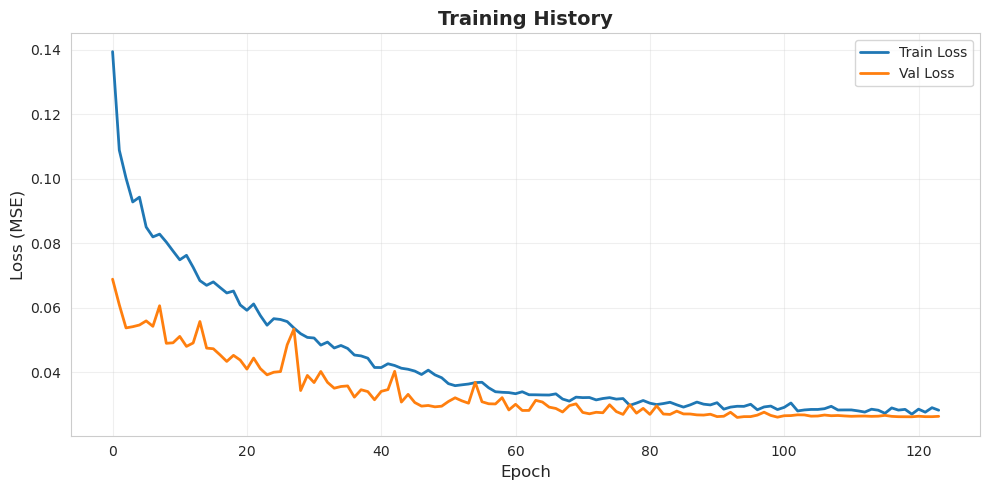

In [35]:
# Plot training history
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (MSE)', fontsize=12)
ax.set_title('Training History', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Evaluate on Test Set

In [36]:
# Predict on test set
y_pred = model.predict(X_test.astype(np.float32), verbose=0).flatten()

# Calculate metrics (convert back to percentage)
rmse = np.sqrt(mean_squared_error(y_test * 100, y_pred * 100))
mae = mean_absolute_error(y_test * 100, y_pred * 100)
r2 = r2_score(y_test, y_pred)

print("="*50)
print("TEST SET PERFORMANCE")
print("="*50)
print(f"RMSE: {rmse:.2f}%")
print(f"MAE:  {mae:.2f}%")
print(f"R²:   {r2:.4f}")
print("="*50)

TEST SET PERFORMANCE
RMSE: 16.28%
MAE:  11.68%
R²:   0.6421


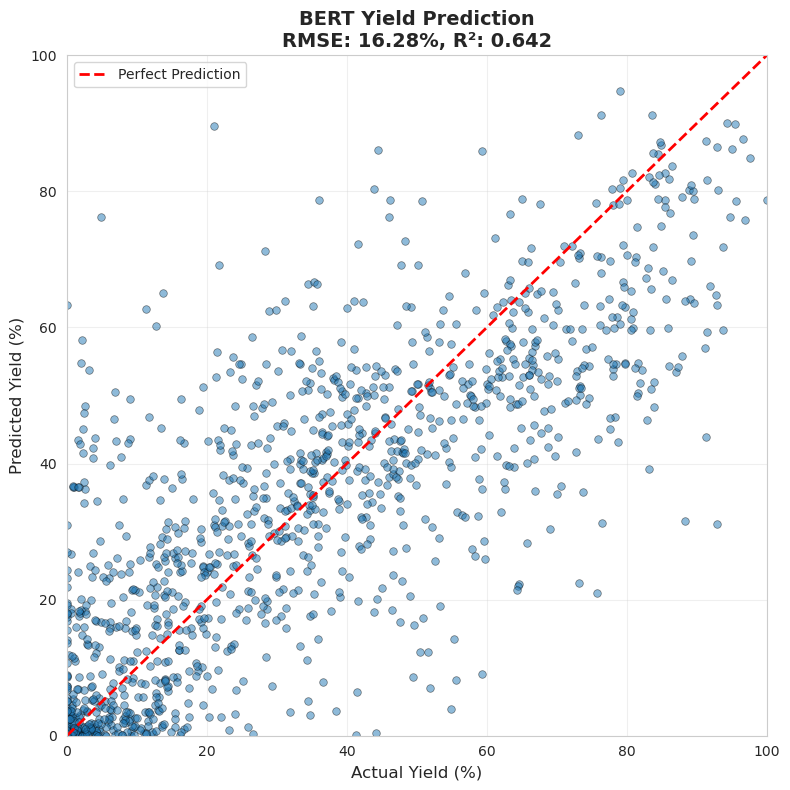

In [37]:
# Scatter plot: Actual vs Predicted
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(y_test * 100, y_pred * 100, alpha=0.5, s=30, edgecolors='black', linewidth=0.5)
ax.plot([0, 100], [0, 100], 'r--', linewidth=2, label='Perfect Prediction')

ax.set_xlabel('Actual Yield (%)', fontsize=12)
ax.set_ylabel('Predicted Yield (%)', fontsize=12)
ax.set_title(f'BERT Yield Prediction\nRMSE: {rmse:.2f}%, R²: {r2:.3f}', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])

plt.tight_layout()
plt.show()

Error statistics:
  Mean error: -0.87%
  Std error:  16.25%
  Within ±10%: 57.1%
  Within ±20%: 80.4%


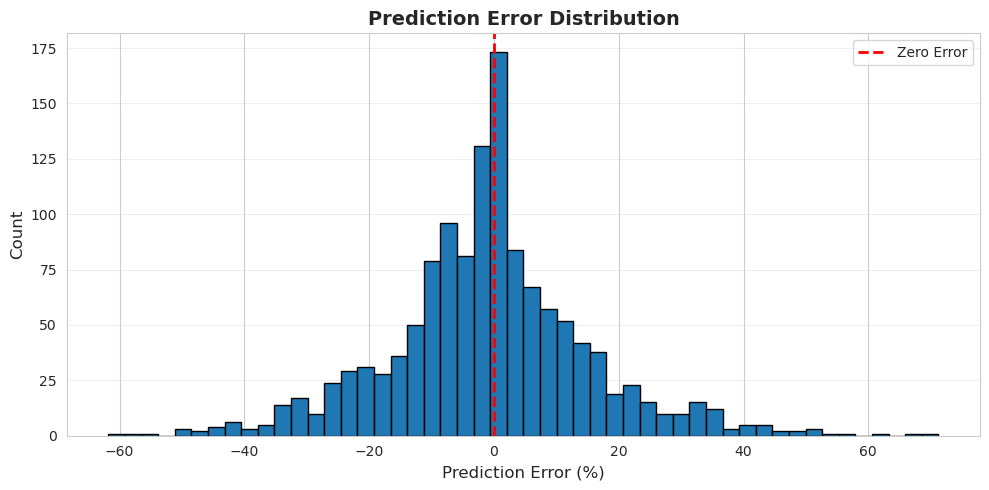

In [38]:
# Error distribution
errors = (y_pred - y_test) * 100

fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(errors, bins=50, edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax.set_xlabel('Prediction Error (%)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Prediction Error Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

print(f"Error statistics:")
print(f"  Mean error: {errors.mean():.2f}%")
print(f"  Std error:  {errors.std():.2f}%")
print(f"  Within ±10%: {(np.abs(errors) <= 10).mean()*100:.1f}%")
print(f"  Within ±20%: {(np.abs(errors) <= 20).mean()*100:.1f}%")

plt.tight_layout()
plt.show()

## 10. Example Predictions

In [39]:
# Show 10 random example predictions
np.random.seed(42)
sample_indices = np.random.choice(len(X_test), 10, replace=False)

print("="*80)
print("EXAMPLE PREDICTIONS")
print("="*80)

for i, idx in enumerate(sample_indices, 1):
    actual = y_test[idx] * 100
    predicted = y_pred[idx] * 100
    error = predicted - actual
    
    # Classification
    actual_class = "Success" if actual >= 50 else "Failure"
    pred_class = "Success" if predicted >= 50 else "Failure"
    correct = "✓" if actual_class == pred_class else "✗"
    
    print(f"\nReaction {i}:")
    print(f"  Actual:    {actual:5.1f}% ({actual_class})")
    print(f"  Predicted: {predicted:5.1f}% ({pred_class}) {correct}")
    print(f"  Error:     {error:+5.1f}%")

EXAMPLE PREDICTIONS

Reaction 1:
  Actual:     63.4% (Success)
  Predicted:  64.0% (Success) ✓
  Error:      +0.6%

Reaction 2:
  Actual:     79.8% (Success)
  Predicted:  54.8% (Success) ✓
  Error:     -25.0%

Reaction 3:
  Actual:     51.2% (Success)
  Predicted:  59.3% (Success) ✓
  Error:      +8.1%

Reaction 4:
  Actual:      0.9% (Failure)
  Predicted:  36.6% (Failure) ✓
  Error:     +35.7%

Reaction 5:
  Actual:     49.0% (Failure)
  Predicted:  37.9% (Failure) ✓
  Error:     -11.2%

Reaction 6:
  Actual:      0.0% (Failure)
  Predicted:   8.9% (Failure) ✓
  Error:      +8.9%

Reaction 7:
  Actual:     36.1% (Failure)
  Predicted:  78.8% (Success) ✗
  Error:     +42.7%

Reaction 8:
  Actual:     35.4% (Failure)
  Predicted:  66.6% (Success) ✗
  Error:     +31.3%

Reaction 9:
  Actual:     42.0% (Failure)
  Predicted:  32.1% (Failure) ✓
  Error:      -9.9%

Reaction 10:
  Actual:     46.6% (Failure)
  Predicted:  40.6% (Failure) ✓
  Error:      -6.1%


## 11. Save Model

In [40]:
# Save the trained model
model.save('yield_model_bert.keras')
print("✓ Model saved as 'yield_model_bert.keras'")

# Save reaction SMILES and embeddings for future use
np.save('reaction_embeddings.npy', X)
df.to_csv('reaction_smiles_data.csv', index=False)
print("✓ Embeddings and data saved")

✓ Model saved as 'yield_model_bert.keras'
✓ Embeddings and data saved


## Summary

### Key Findings

**Approach:** Used pre-trained RXNBERT to encode entire reactions as 256-dimensional vectors, then trained a simple neural network for yield prediction.

**Advantages over one-hot encoding:**
- Captures chemical structure and similarity
- Can potentially extrapolate to novel components
- Uses pre-trained chemical knowledge
- Encodes the entire reaction context

**Results:** See test set metrics above

**Comparison to one-hot baseline (RMSE: 7.0%, R²: 0.93):**
- BERT results: [see above]

**Next steps:**
- Fine-tune RXNBERT on this specific dataset
- Explore different neural network architectures
- Test generalization to new reaction components